# PyTorch Workflow

In [114]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# check PyTorch Version
torch.__version__

'2.1.0+cu121'

## 1. Data (preparing and loading)

In [115]:
# Create known parameters
weight = 0.7
bias = 0.3

# create
start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim = 1)
y = weight * X + bias
X.shape,X[:10], y[:10], len(X), len(y)

(torch.Size([50, 1]),
 tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Spliting the data into training and test sets

In [116]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train),len(y_train),len(X_test),len(y_test)

(40, 40, 10, 10)

Visualize the data

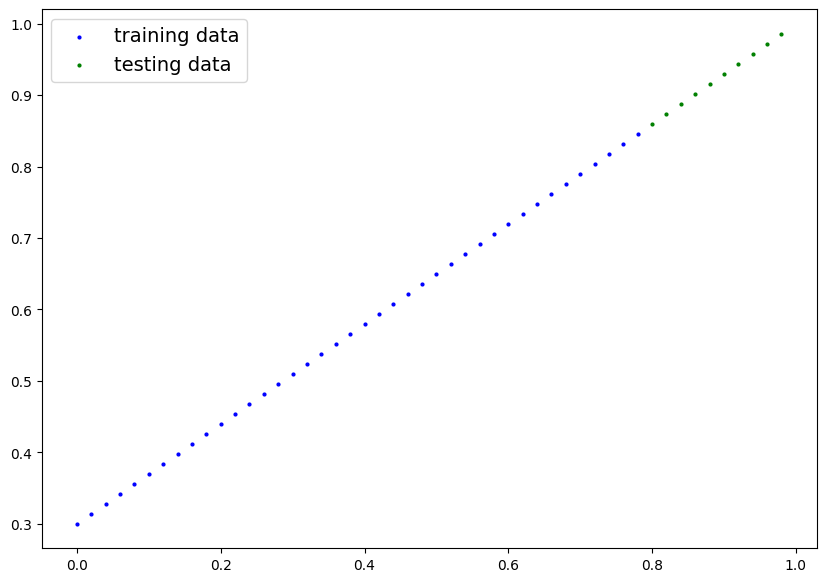

In [117]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    '''Plots training data, test data and compares predictions'''
    plt.figure(figsize=(10,7))

    # plot the training data in blue
    plt.scatter(train_data, train_labels, c='b', s=4, label='training data')
    # plot the test data in green
    plt.scatter(test_data, test_labels, c='g', s=4, label='testing data')

    if predictions is not None:
        #plot predictions if they exist
        plt.scatter(test_data, predictions, c= 'r', label='predictions')
    plt.legend(prop={'size':14});

plot_predictions()


## 2. First PyTorch Model

* Start with random values (weights and heights)
* Look at training data and adjsut the random values to better represent the ideal values (the weight and bias values we use to create the data)

HOW?

Through two main algorithms
1. Gradient descent: https://www.youtube.com/watch?v=IHZwWFHWa-w
2. Backpropagation: https://www.youtube.com/watch?v=Ilg3gGewQ5U

In [118]:
# reate linear regression model class

class LinearRegressionModel(nn.Module): # Almost everything in PyTorch inherits from from nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float))

    # forward method to define the computtaion in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
            return self.weights * x + self.bias  # Linear regression formula


* torch.nn	Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way).
* torch.nn.Parameter	Stores tensors that can be used with nn.Module. If requires_grad=True gradients (used for updating model parameters via gradient descent) are calculated automatically, this is often referred to as "autograd".
* torch.nn.Module	The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass nn.Module. Requires a forward() method be implemented.
* torch.optim	Contains various optimization algorithms (these tell the model parameters stored in nn.Parameter how to best change to improve gradient descent and in turn reduce the loss).
* def forward()	All nn.Module subclasses require a forward() method, this defines the computation that will take place on the data passed to the particular nn.Module (e.g. the linear regression formula above).

### Checking the contents of our PyTorch Model

We cancheck our model parameters or what i inside the model using .parameters().

In [119]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model, which is a sub-class of nn.module

model_0 = LinearRegressionModel()

# Check out parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [120]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using 'torch.inference_mode()'

to check our model's predictive power, let's see how well it predicts  'y_test' based on 'X_test'

when passing data through model, it is going to run through the forward() method

In [121]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [122]:
# making predictions with model
with torch.inference_mode(): #the inference mode disables the gradient tracking  You can also do something similar with torch.no_grad(), however, inference_mode is preferred
    Y_preds = model_0(X_test)

Y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

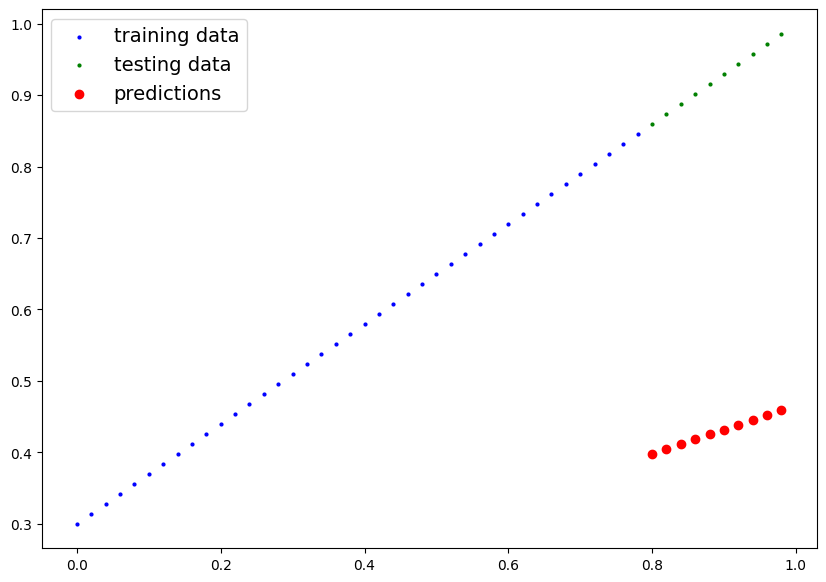

In [123]:
plot_predictions(predictions=Y_preds)

## 3. Training Model

One way to measure how poorly the model does is to use the loss function

* Note: Loss function may also be called cost function or criterion in different areas.
* **Loss Function:** A function to measure how wrong your model's prediction are to the idea outputs, lower is better
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weights and bias in our case) to improve the loss function

and specifically for PyTorch, we need:
* A training loop
* A testing loop

In [124]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [125]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [126]:
# Set up a loss function
loss_fn = nn.L1Loss()

# Set up an optimizer(Stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.01) # Learning rate = possibly the most important hyperparameter you can set



### Building a training loop (and a testing loop)

A couple of things we need in a training loop
0. Loop through the data and do...
1. Forward pass (This involves data moving thorugh our model's forward() functions) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to groud truth labels)
3. Optimizer zero grad
4. Loss backward - move backward through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**Backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's paramaters to try and improve the loss (**Gradient descent**)

In [127]:
# An epoch is one loop through the data... this is a hyperparameter because we set it ourselves
epochs = 200

# track different values
epoch_count = []
loss_values = []
test_loss_values = []

# 0. loop throught the data
for epoch in range(epochs):
    # set the model to training mode
    model_0.train() # train mode in PyTorch set all parameters that require gradients to require gradients

    # 1. forward pass
    y_pred = model_0(X_train)

    # 2. calculate the loss
    loss = loss_fn(y_pred, y_train) # prediction first and labels second



    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. perform backpropagation on the loss with respect to the parameter of the model
    loss.backward()


    # 5. step the optimizer (perform gradient descent)
    optimizer.step() # by default how the optimizer changes will accumulate through the loop so... we have to zero them above in step 3 for the next iteration of the loop

    ### testing
    model_0.eval() # turns off settings that are not needed in model evaluation/testing (dropout/batch norm layers)
    with torch.inference_mode(): # this turns off gradient tracking and a couple more things behind the scenes
        # 1. do the forward pass
        test_pred = model_0(X_test)

        # 2. calculate the loss
        test_loss = loss_fn(test_pred, y_test)
    # printing out what is happening
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f'Epoch: {epoch} | Test: {loss} | Test loss: {test_loss}')

        # print out the model state
        print(model_0.state_dict())


Epoch: 0 | Test: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Test: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Test: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Test: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Test: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Test: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Test: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

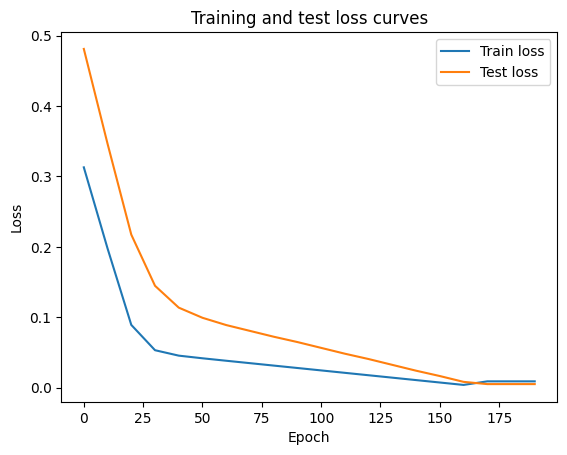

In [128]:
# Plot the loss curve
plt.plot(epoch_count, torch.tensor(loss_values).numpy(), label='Train loss')
plt.plot(epoch_count,test_loss_values, label='Test loss')
plt.title('Training and test loss curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend();


In [129]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

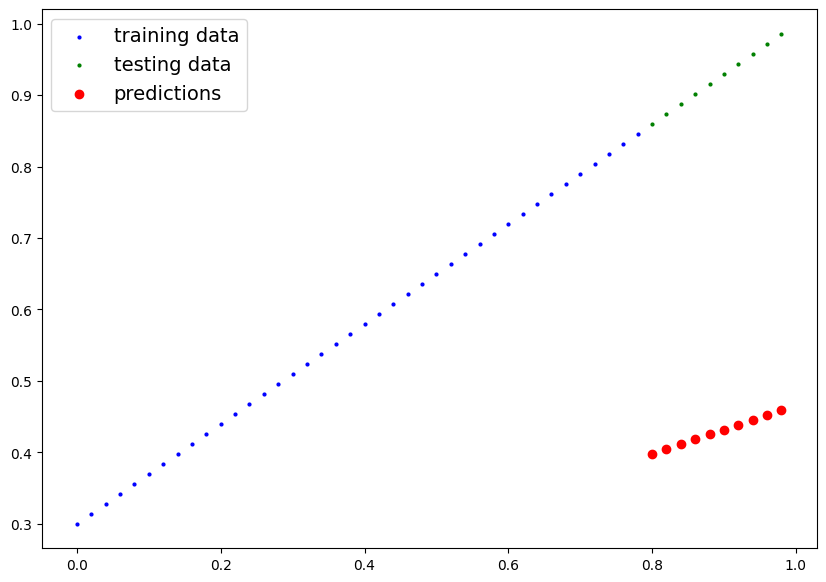

In [130]:
plot_predictions(predictions=Y_preds)

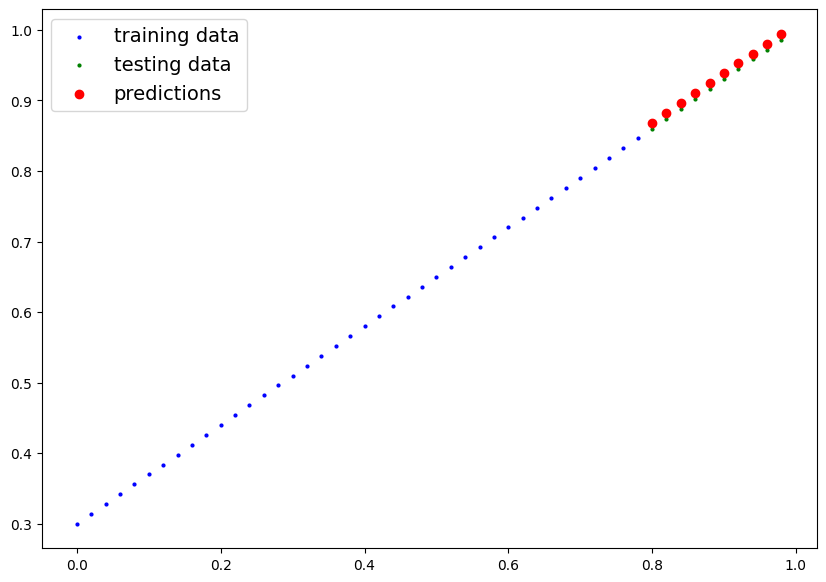

In [131]:
plot_predictions(predictions=y_preds_new)


## 4. Saving a model in PyTorch
There are three main methods for saving an dloading models in PyTorch
1. 'torch.save()' - allows you to save a PyTorch object with Python's pickle format
2. 'torch.load()' - allows you to load a saved PyTorch object
3. 'torch.nn.Module.load_state_dict()' - this allows you to load a model's saved state dictionary

In [132]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [135]:
# Saving the PyTorch model
from pathlib import Path

# 1. create a model directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True,exist_ok=True)

# 2. create model save path
MODEL_NAME = '1_PyTorch_Workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

# 3. Save the model state dictionary
print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=model_0.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to: models/1_PyTorch_Workflow_model_0.pth


In [136]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1674 Dec 18 20:50 1_PyTorch_Workflow_model_0.pth


## 5. Loading a PyTorch model

Since we saved our model's state_dict()' rather than the entire model, we will create a new instance of our model class and load the saved 'state_dict()' into that

In [137]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [141]:
# to load in save state_dict we have to isntantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# load the saved state_dict() of mode_0

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [149]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [150]:
# make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_0_preds = loaded_model_0(X_test)

loaded_model_0_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [152]:
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)
y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [153]:
y_preds == loaded_model_0_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# 6. Putting all togehter

### 6.1 Data

In [ ]:
# create some data using the linear regression formula of y = weight * x + bias

weight = 0.7
bias = 0.3

# create range values
start = 0
end = 1
step = 0.02

# create X and y (features and labels)
X = torch.arange(start,end,step).unsqueeze(dim=1) # without unsquezze erros will pop up
y = weight * X + bias



In [159]:
# split the data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_test)

(40, 10)

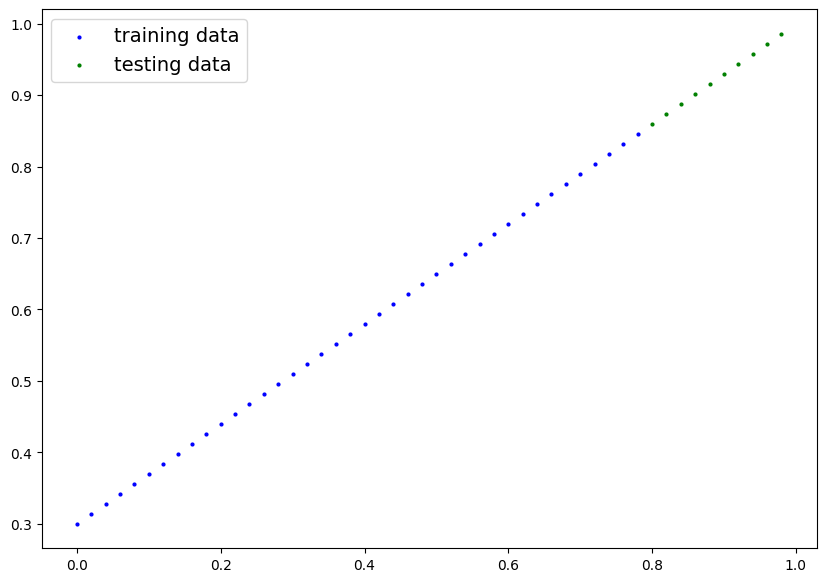

In [160]:
# plot the data
# if you dont have the plot_predictions loaded this will error

plot_predictions(X_train,y_train,X_test,y_test)

### 6.2 Building a PyTorch Linear model

In [162]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [163]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

### 6.3 training

for training we need:
* Loss function
* optimizer
* training loop
* testing loop

In [170]:
# Set up loss function
loss_fn = nn.L1Loss() # Same as MAE

# Set up optimizer
optimier = torch.optim.SGD(params=model_1.parameters(),
                           lr=0.01)



In [171]:
# Training loop
torch.manual_seed(42)
epochs = 200
for epoch in range(epochs):
    model_1.train()

    # 1. Forward Pass
    y_pred = model_1(X_train)

    # 2. calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimier.zero_grad()

    # 4. backpropagation
    loss.backward()

    # 5. Optimizer step
    optimier.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)

        test_loss = loss_fn(test_pred, y_test)

        # print out what is happening
        if epoch % 10 == 0:
            print(f'Epoch: {epoch} | Loss: {loss}| test loss: {test_loss}')

Epoch: 0 | Loss: 0.5551779866218567| test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.4399680495262146| test loss: 0.4392663538455963
Epoch: 20 | Loss: 0.3247582018375397| test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954827964305878| test loss: 0.16984674334526062
Epoch: 40 | Loss: 0.09433844685554504| test loss: 0.03513689711689949
Epoch: 50 | Loss: 0.023886386305093765| test loss: 0.04784906655550003
Epoch: 60 | Loss: 0.0199567973613739| test loss: 0.04580312222242355
Epoch: 70 | Loss: 0.016517987474799156| test loss: 0.0375305712223053
Epoch: 80 | Loss: 0.013089170679450035| test loss: 0.029944902285933495
Epoch: 90 | Loss: 0.009653178043663502| test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215679459273815| test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.002787243574857712| test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314| test loss: 0.013801807537674904
Epoch: 130 | Loss: 0.0012645035749301314| test loss: 0.013801807537674904
Epoch: 14

In [173]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

### 6.4 Making and evaluating predictions

In [175]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

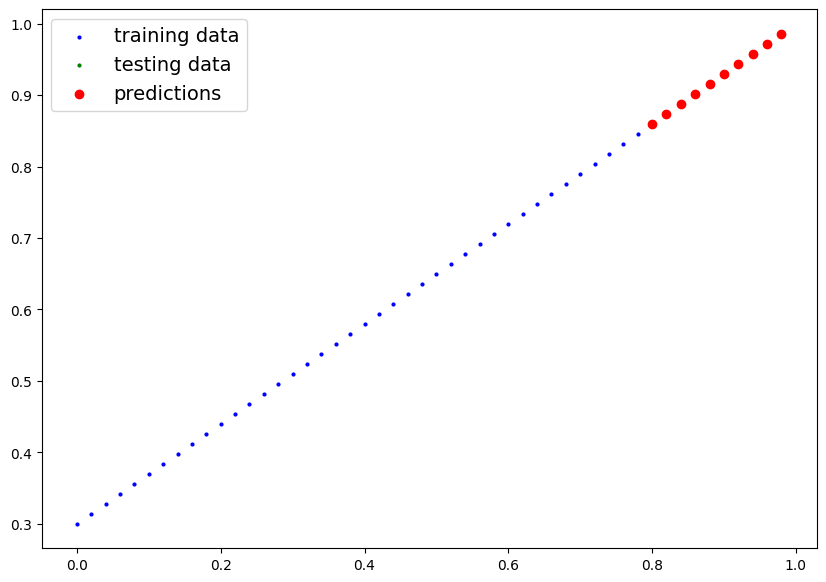

In [176]:
# Check the prediction visually
plot_predictions(predictions=y_preds)

### 6.5 saving and loading the model

In [179]:
from pathlib import Path

# 1. create the model directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True,exist_ok=True)

# 2. Create model save path
MODEL_NAME = '1_PyTorch_Workflow_model_1.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state_dict
print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)


Saving model to: models/1_PyTorch_Workflow_model_1.pth


In [180]:
# Load a PyTorch

# Create a new instance
loaded_model_1 = LinearRegressionModelV2()

# Load the saved model_1 state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))



<All keys matched successfully>

In [181]:
next(loaded_model_1.parameters()).device

device(type='cpu')

In [182]:
# evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])